# Diversity Condition Violated Correct Model

This is a notebook that performs the experiment when the diversity condition is violated and we select a correct model to adjust for that.

- $p(\tilde{z}|z) = \delta(u - u') \frac{e^{\kappa}\tilde{z}^{T}z}{\int_{W(z)}e^{\kappa z^{T}z'}dz'}$ - model conditional density
- $q_{h}(\tilde{z}|z) = \delta(u-u') \frac{e^{\frac{1}{\tau} h(\tilde{z})^{T}h(z)}}{\int_{W(z)}e^{\frac{1}{\tau}h(z)^{T}h(z')}dz'}$ - Model conditional density

The loss function in this setup will be the following:

$\mathcal{L} = \mathbb{E}_{(z, \tilde{z}) \sim p(z, \tilde{z}), \{z^{-}_{i}\} \sim U(\mathcal{W}(z)) }[- \log(\frac{e^{\frac{1}{\tau}h(\tilde{z})^{T}h(z)}}{\Sigma_{i=1}^{M}e^{\frac{1}{\tau} h(\tilde{z})^{T}h(z^{-}_{i})}})]$

The plan is to do the experiments with the following data generating processess:

- 

In [15]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
from torch import functional

from spaces import NSphereSpace
from visualization_utils.spheres import visualize_spheres_side_by_side, scatter3d_sphere
import matplotlib.pyplot as plt
from evals.disentanglement import linear_disentanglement, permutation_disentanglement
from visualization_utils.scoring import plot_scores

full_sphere = NSphereSpace(3)
sub_sphere = NSphereSpace(2)

class SimCLRAdjusted(nn.Module):
    def __init__(self, d, d_fix, neg_samples, decoder, encoder, sample_pair, sample_negative, tau=0.1, device=None):
        super(SimCLRAdjusted, self).__init__()
        self.d = d
        self.d_fix = d_fix
        self.neg_samples = neg_samples
        self.tau = tau
        self.decoder = decoder
        self.encoder = encoder
        self.sample_pair = sample_pair
        self.sample_negative = sample_negative
        self.device = device if device else ('cuda' if torch.cuda.is_available() else 'cpu')
        self.decoder.to(self.device)
        self.encoder.to(self.device)

    def loss(self, Z_enc, Z_pos_enc, Z_neg_enc):
        neg = torch.logsumexp((Z_enc.unsqueeze(1) * Z_neg_enc).sum(dim=2) / self.tau, dim=1).mean()
        pos = - (Z_enc * Z_pos_enc).sum(dim=1).mean() / self.tau

        return neg + pos, neg, pos

    def train(self, batch_size, iterations):
        for p in self.decoder.parameters():
            p.requires_grad = False

        adam = torch.optim.Adam(self.encoder.parameters(), lr=1e-4)

        h = lambda latent: self.encoder(self.decoder(latent.to(self.device)))

        # --- Evaluation on latent space before training
        control_latent, _ = self.sample_pair(batch_size)
        control_latent = control_latent.to(self.device)

        linear = linear_disentanglement(control_latent, control_latent)
        print("Linear control score:", linear[0][0])

        perm = permutation_disentanglement(control_latent, control_latent)
        print("Permutation control score:", perm[0][0])

        linear_scores = []
        perm_scores = []

        for i in range(iterations):
            z, z_sim = self.sample_pair(batch_size)

            z = z.to(self.device)
            z_sim = z_sim.to(self.device)

            z_neg = self.sample_negative(z, self.neg_samples).to(self.device)
            z_enc = h(z)
            z_enc_sim = h(z_sim)
            z_enc_neg = h(z_neg)

            loss_result, neg, pos = self.loss(z_enc, z_enc_sim, z_enc_neg)

            loss_result.backward()
            adam.step()
            

            if i % 20 == 1:
                lin_dis, _ = linear_disentanglement(z.cpu(), z_enc.cpu())
                lin_score, _ = lin_dis

                perm_dis, _ = permutation_disentanglement(z.cpu(), z_enc.cpu())
                perm_score, _ = perm_dis

                linear_scores.append(lin_score)
                perm_scores.append(perm_score)

                print('Loss:', loss_result.item(), 'Samples processed:', i,
                      "linear disentanglement:", lin_score,
                      'permutation disentanglement:', perm_score,
                      'Negative:', neg.item(),
                      'Positive:', pos.item())
                
        self.encoder.eval()

        return self.encoder, {'linear_scores': linear_scores, 'perm_scores': perm_scores}

d_fix = 1
d = 3
kappa = 8
tau = 1 / kappa
batch_size = 2000
neg_samples = 1000
iterations = 1000

# Sampling negative samples in the case where the model of the latent space has violated diversity condition, but our model adjusts for that
def sample_negative_samples(Z, M):
    z_fixed = Z[:, :d_fix].to(device)

    radii = torch.sqrt(1 - (z_fixed ** 2).sum(dim=1)).to(device)  # Radius of the sub-sphere
    neg_samples = torch.randn(Z.shape[0], M, d - d_fix, device=device)

    neg_samples = neg_samples / (neg_samples.norm(dim=2, keepdim=True) + 1e-8)  # Normalize the samples + add some margin for error
    neg_samples = neg_samples * radii.view(-1, 1, 1)

    return torch.cat((z_fixed.unsqueeze(1).expand(-1, M, -1), neg_samples), dim=2)


def sample_conditional_with_dims_fixed(z, batch, u_dim):
    u = z[:, :u_dim].to(device)
    v = z[:, u_dim:].to(device)

    v_norm = torch.nn.functional.normalize(v, dim=-1, p=2).to(device)
    aug_samples_v = sub_sphere.von_mises_fisher(v_norm, kappa, batch).to(device) * torch.norm(v, p=2, dim=-1, keepdim=True).to(device)

    return torch.cat((u, aug_samples_v), dim=-1)


def sample_pair_with_fixed_dimension(batch, u_dim):
    z = full_sphere.uniform(batch).to(device)  # (N, 3)
    
    return z, sample_conditional_with_dims_fixed(z, batch, u_dim)

sample_pair_fixed = lambda batch: sample_pair_with_fixed_dimension(batch, d_fix)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print("Using device:", device)

torch.cuda.empty_cache()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


## Visualizing the sampling processess

- Uniform Sampling
- Conditional Sampling
- Negative sample sampling

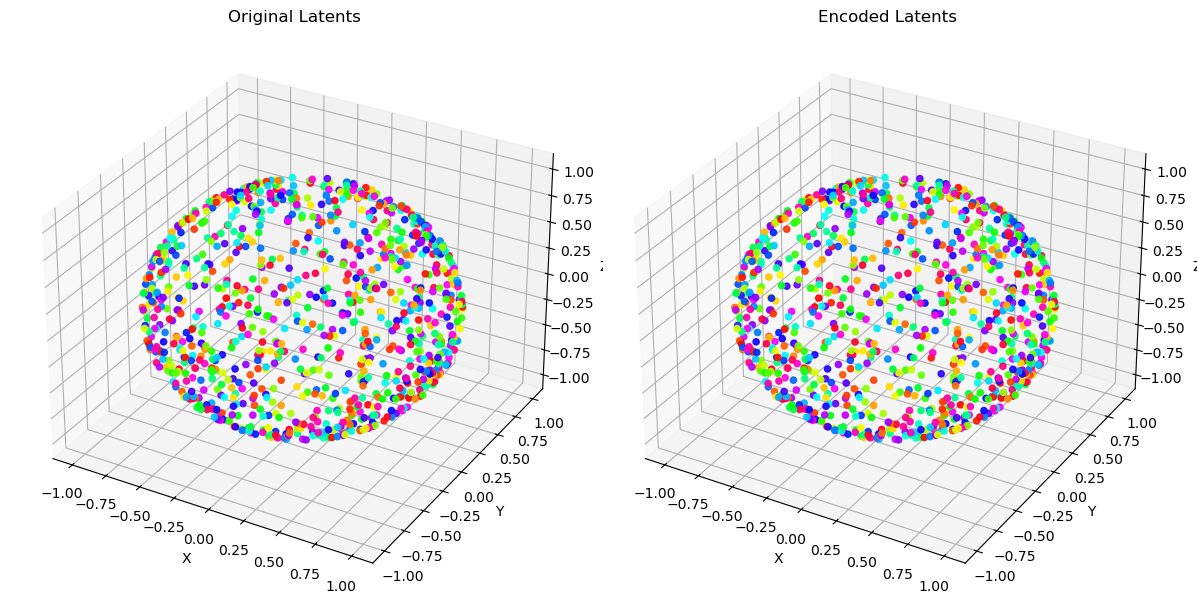

In [13]:
## Uniform sampling

s = full_sphere.uniform(1000)

visualize_spheres_side_by_side(plt, s, s)

tensor([ 0.7828,  0.1372, -0.6069])


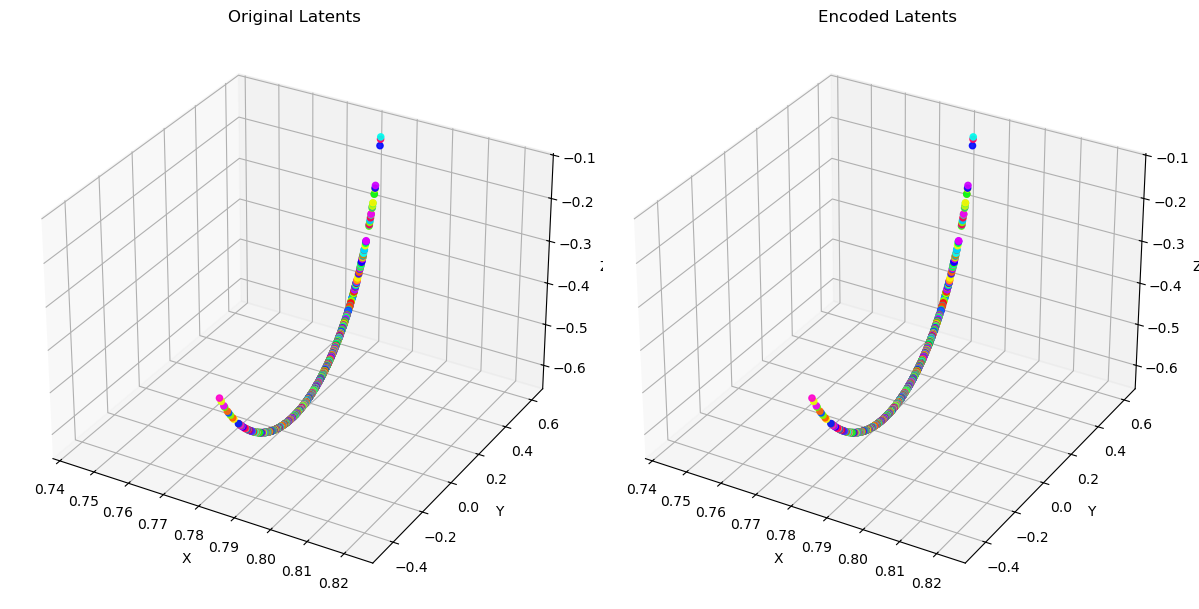

In [14]:
## Visualizing similar sample sampling

z = full_sphere.uniform(1).squeeze(0)

print(z)

u = z[:1]
v = z[1:]

v_norm = torch.nn.functional.normalize(v, dim=-1, p=2)
aug_samples_v = sub_sphere.von_mises_fisher(v_norm, kappa, 1000) * torch.norm(v, p=2, dim=-1, keepdim=True)

z_aug = torch.cat((u.expand(1000, 1), aug_samples_v), dim=-1)

visualize_spheres_side_by_side(plt, z_aug, z_aug)

z shape: tensor([[0.3722, 0.7242, 0.5806]])
SHAPE OF NEGATIVE SAMPLES torch.Size([1000, 3])
MAX tensor(1.0000, device='cuda:0')
MIN tensor(1.0000, device='cuda:0')


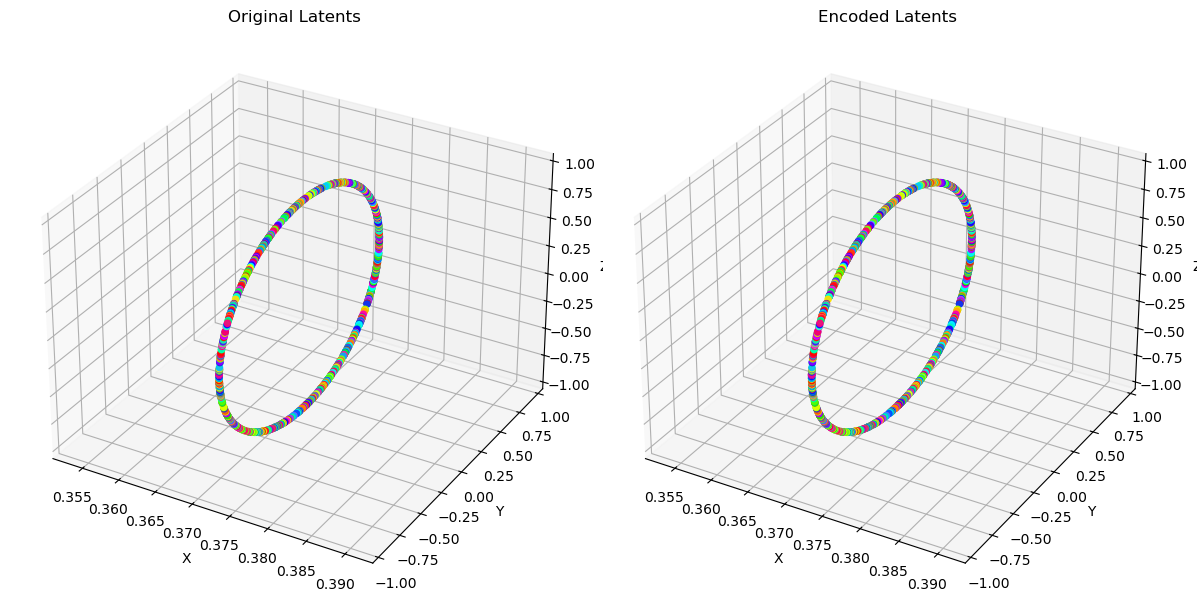

In [15]:
## Visualizing the negative sample sampling

z = full_sphere.uniform(1)

print("z shape:", z)

negative_samples = sample_negative_samples(z, 1000).squeeze(0)

print('SHAPE OF NEGATIVE SAMPLES', negative_samples.shape)
print("MAX", (negative_samples ** 2).sum(dim=1).max())
print("MIN", (negative_samples ** 2).sum(dim=1).min())

visualize_spheres_side_by_side(plt, negative_samples, negative_samples)

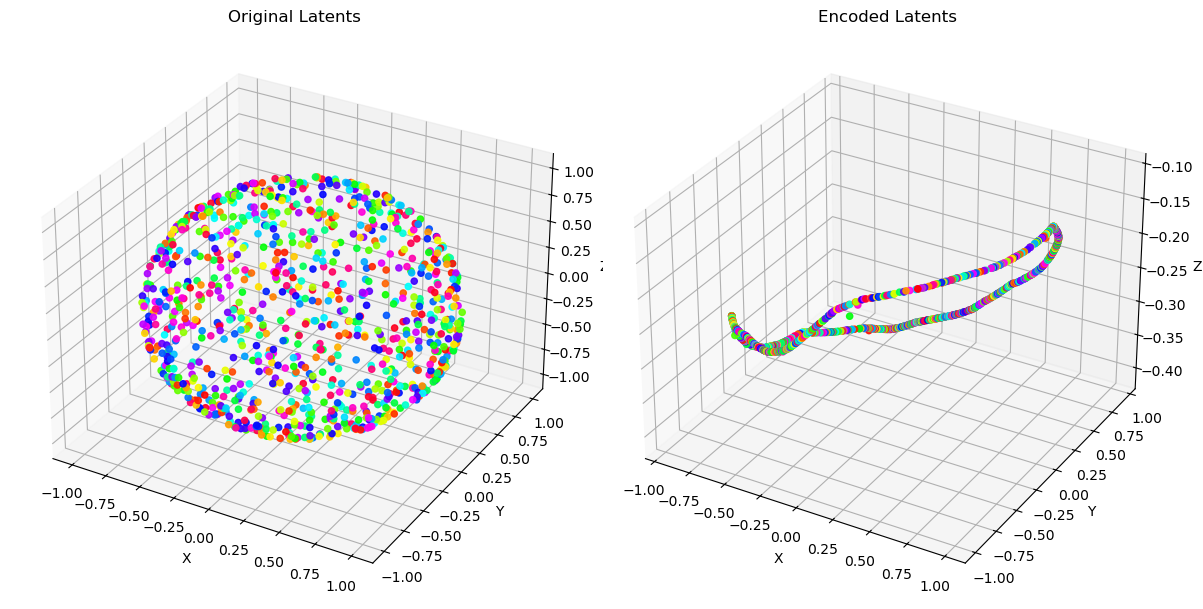

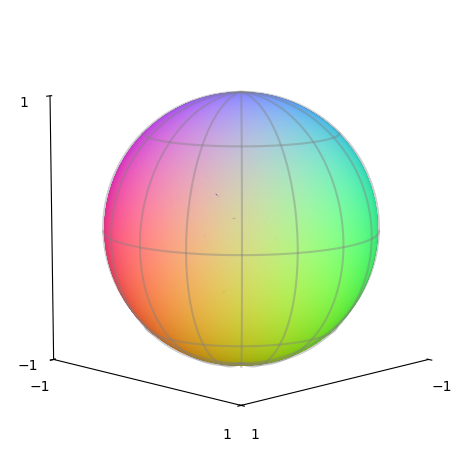

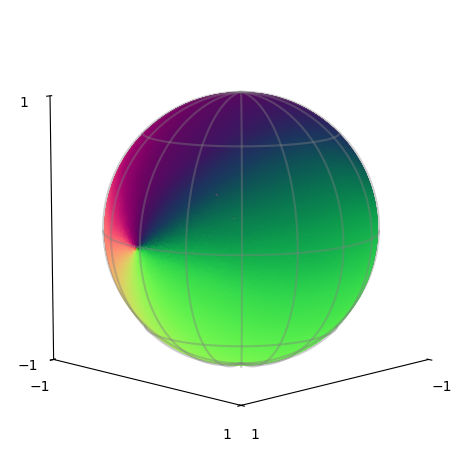

In [ ]:
from encoders import get_mlp

# Initialize the multi-layer perceptron used for encoding
f_constrained_id = get_mlp(
    n_in=3,
    n_out=3,
    layers=[
        3 * 10,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 10,
    ],
    output_normalization="fixed_sphere",
).to("cpu")

g_id = nn.Identity()

sim_clr_identity = SimCLRAdjusted(
    d=d,
    d_fix=d_fix,
    neg_samples=neg_samples,
    decoder=g_id,
    encoder=f_constrained_id,
    sample_pair=sample_pair_fixed,
    sample_negative=sample_negative_samples,
    tau=tau,
    device=device
)

f_constrained_id, scores = sim_clr_identity.train(
    batch_size=batch_size,
    iterations=iterations,
)

torch.cuda.empty_cache()

plot_scores(plt, scores)

h_constrained = lambda z: f_constrained_id(g_id(z))

z = full_sphere.uniform(1000)
z_enc = h_constrained(z).to(device)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

z = full_sphere.uniform(100000)
z_enc = h_constrained(z).to(device)

fig = scatter3d_sphere(plt, z.cpu(), z.cpu(), s=10, a=.8)
fig = scatter3d_sphere(plt, z.cpu(), z_enc.cpu(), s=10, a=.8)

In [13]:
from data.generation import InjectiveLinearDecoder
from encoders import construct_mlp_encoder

def perform_linear_experiment(data_dim):
    g_linear = InjectiveLinearDecoder(3, data_dim)
    f = construct_mlp_encoder(data_dim, 3)

    sim_clr_4d = SimCLRAdjusted(
        d=d,
        d_fix=d_fix,
        neg_samples=neg_samples,
        decoder=g_linear,
        encoder=f,
        sample_pair=sample_pair_fixed,
        sample_negative=sample_negative_samples,
        tau=tau,
        device=device
    )

    f, scores = sim_clr_4d.train(
        batch_size=batch_size,
        iterations=iterations,
    )
    torch.cuda.empty_cache()

    plot_scores(plt, scores)

    h = lambda z: f(g_linear(z))
    z = full_sphere.uniform(1000).to(device)
    z_enc = h(z)

    visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())


    z = full_sphere.uniform(100000).to(device)
    z_enc = h(z)
    
    fig = scatter3d_sphere(plt, z.cpu(), z.cpu(), s=10, a=.8)
    fig = scatter3d_sphere(plt, z.cpu(), z_enc.cpu(), s=10, a=.8)


Linear control score: 1.0
Permutation control score: 1.0
Loss: 6.9067888259887695 Samples processed: 1 linear disentanglement: 0.5206298232078552 permutation disentanglement: 0.00017750263214111328 Negative: 14.906696319580078 Positive: -7.999907493591309
Loss: 6.795584678649902 Samples processed: 21 linear disentanglement: 0.6243752837181091 permutation disentanglement: 0.11327651888132095 Negative: 14.786786079406738 Positive: -7.991201400756836
Loss: 6.30401086807251 Samples processed: 41 linear disentanglement: 0.6008375287055969 permutation disentanglement: 0.13847368955612183 Negative: 14.149435043334961 Positive: -7.845424175262451
Loss: 6.222038269042969 Samples processed: 61 linear disentanglement: 0.5517316460609436 permutation disentanglement: 0.05022849515080452 Negative: 13.619735717773438 Positive: -7.397697448730469
Loss: 5.849237442016602 Samples processed: 81 linear disentanglement: 0.5980373024940491 permutation disentanglement: 0.009900231845676899 Negative: 13.59779

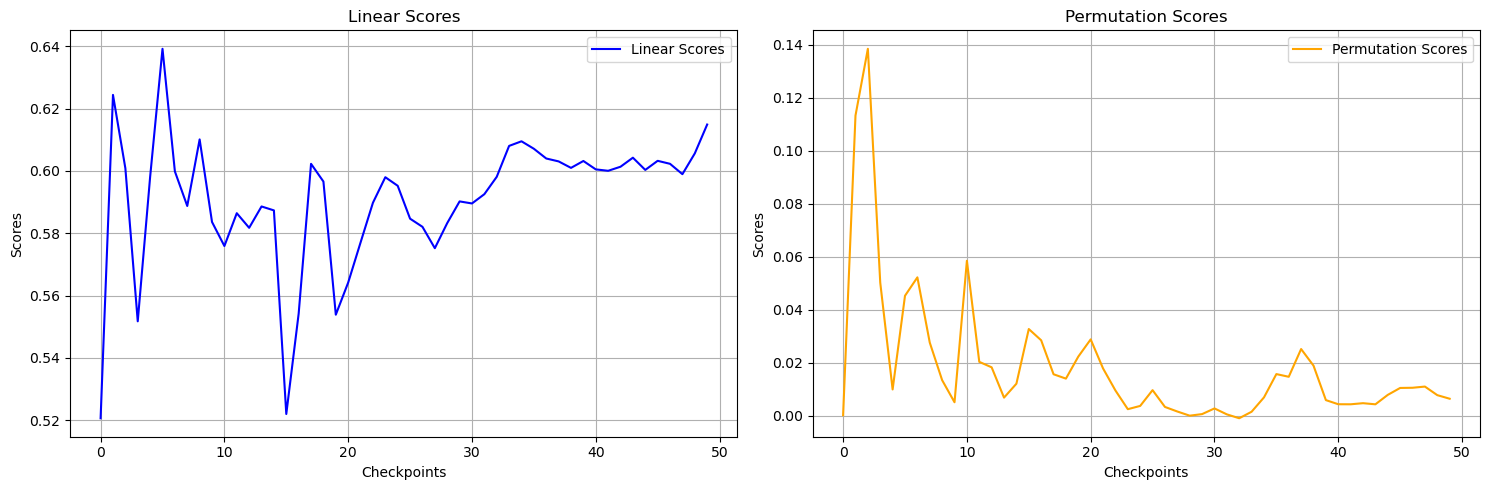

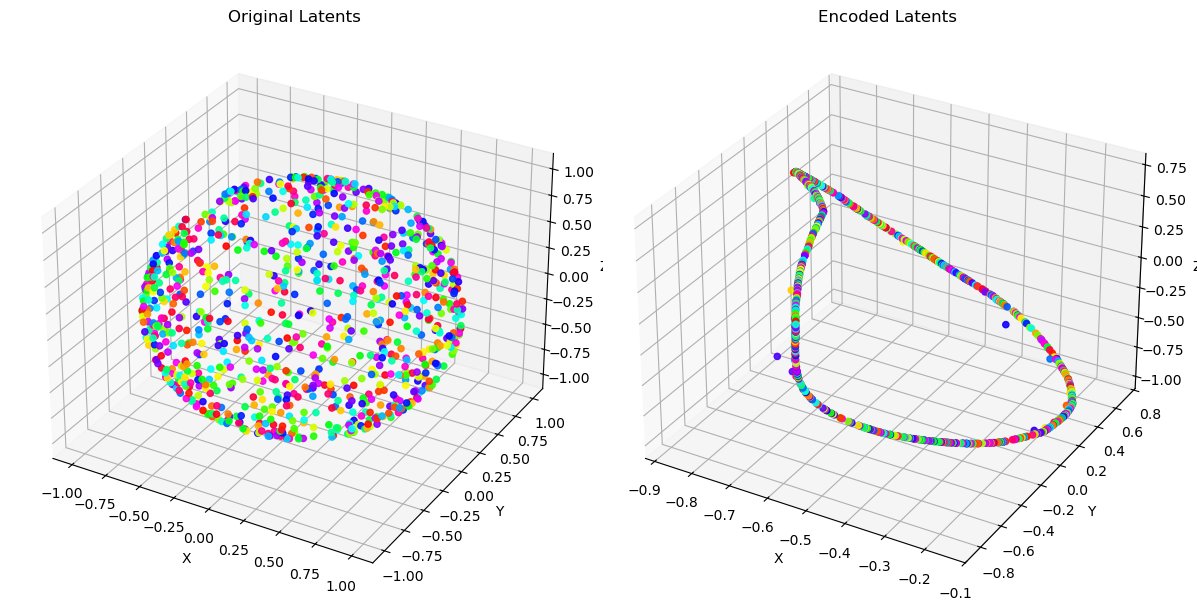

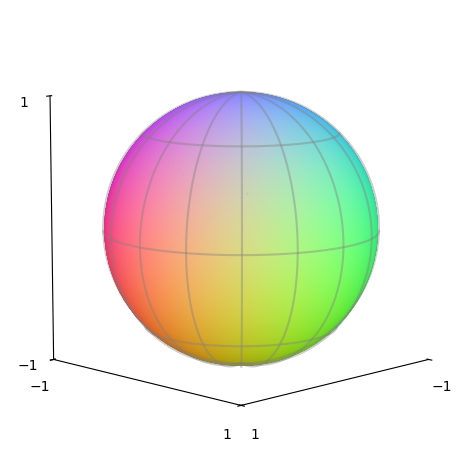

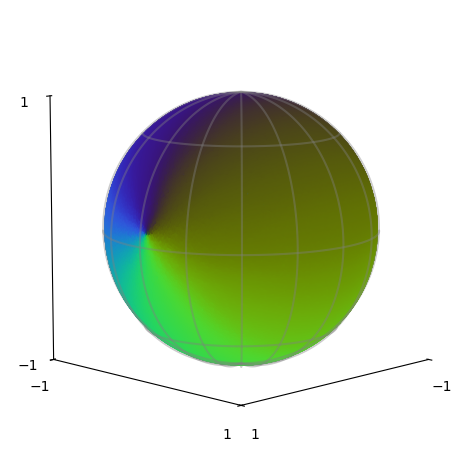

In [16]:
torch.cuda.empty_cache()
perform_linear_experiment(4)

Linear control score: 1.0
Permutation control score: 1.0
Loss: 7.242066860198975 Samples processed: 1 linear disentanglement: 0.3809807300567627 permutation disentanglement: 8.577108383178711e-05 Negative: 15.241653442382812 Positive: -7.999586582183838
Loss: 6.888228893280029 Samples processed: 21 linear disentanglement: 0.38903799653053284 permutation disentanglement: 0.010810792446136475 Negative: 14.830894470214844 Positive: -7.9426655769348145
Loss: 6.712337493896484 Samples processed: 41 linear disentanglement: 0.4335770606994629 permutation disentanglement: 0.05162835121154785 Negative: 14.289519309997559 Positive: -7.577181816101074
Loss: 6.585205078125 Samples processed: 61 linear disentanglement: 0.4984228312969208 permutation disentanglement: 0.0867331251502037 Negative: 14.373719215393066 Positive: -7.788514137268066
Loss: 6.791327476501465 Samples processed: 81 linear disentanglement: 0.5665220618247986 permutation disentanglement: 0.0889471173286438 Negative: 14.716920852

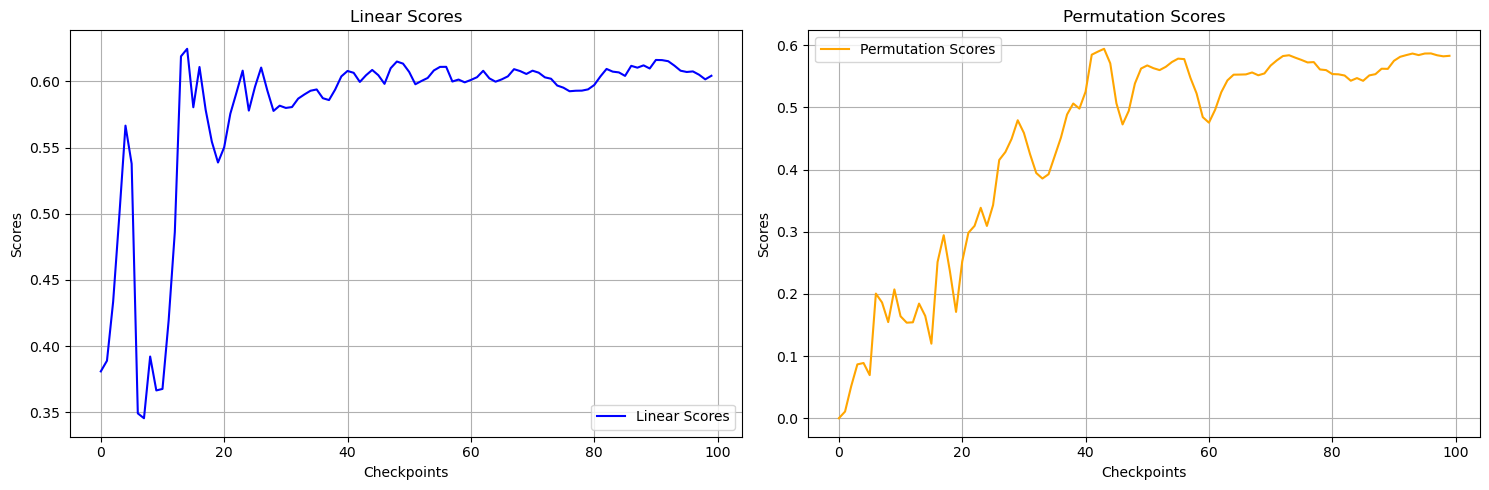

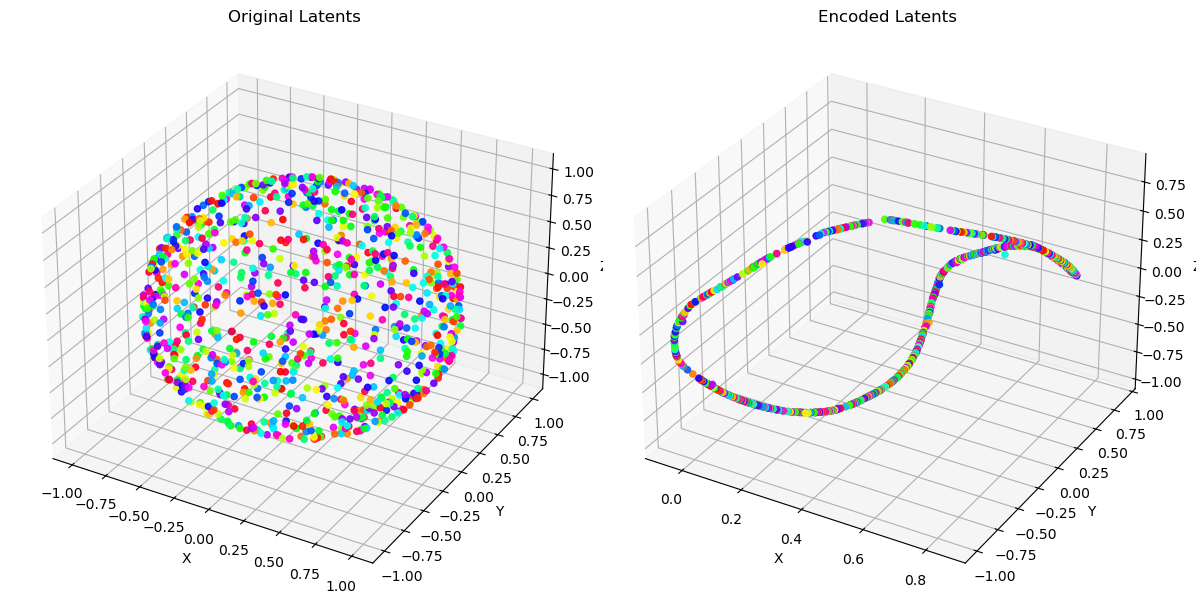

In [8]:
torch.cuda.empty_cache()
perform_linear_experiment(5)

In [6]:
torch.cuda.empty_cache()
perform_linear_experiment(6)

NameError: name 'perform_linear_experiment' is not defined

In [20]:
from data.generation import SpiralRotation

f_spiral = get_mlp(
    n_in=3,
    n_out=3,
    layers=[
        3 * 10,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 10,
    ],
    output_normalization="fixed_sphere",
).to(device)

g_spiral = SpiralRotation(2)

sim_clr_spiral = SimCLRAdjusted(
    d=d,
    d_fix=d_fix,
    neg_samples=neg_samples,
    decoder=g_spiral,
    encoder=f_spiral,
    sample_pair=sample_pair_fixed,
    sample_negative=sample_negative_samples,
    tau=tau,
    device=device
)


f_spiral, scores = sim_clr_spiral.train(batch_size=batch_size, iterations=iterations)
torch.cuda.empty_cache()

plot_scores(plt, scores)

h = lambda z: f_spiral(g_spiral(z))
z = full_sphere.uniform(1000).to(device)
z_enc = h(z)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())


Linear control score: 1.0
Permutation control score: 1.0


RuntimeError: Sizes of tensors must match except in dimension 2. Expected size 2000 but got size 1000 for tensor number 1 in the list.